# Titre....

## Introduction ##

POI : Point Of Interest

Déf de réseau ferré

On dispose de données sur le nombre de validations dans les stations de métro, de RER et de transilien (train) et pour chaque ligne du réseau de surface. L'objectif est d'expliquer la fréquentation des stations par l'environnement urbain autour d'elles et par leur place au sein du réseau de transport (c'est-à-dire le nombre de lignes qui y passent, et éventuellement le nombre de trains par heure qui y passent).

**Hypothèses :**

H1. Les stations en nœuds du réseau (forte centralité) ont plus de trafic.

H2. Les pôles d’attractivité (commerces, écoles, hôpitaux, musées, stades) augmentent le trafic.

H3. La qualité de service (fréquence, amplitude horaire) explique une part spécifique.


## I. Collecte des données

Attention : le code peut être exécuté mais la partie concernant les POI est très longue à calculer (entre 30 minutes et 1 heure). C'est pourquoi tous les fichiers sont stockés dans le dépôt pour être utilisables directement.

### Importations

In [ ]:
import os
import io
import zipfile
import requests
import pandas as pd
from pathlib import Path

In [1]:
! pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [osmnx]kx]


### Set up

In [ ]:
# Chemins
DATA_DIR = Path("Projet-data-science/data")
GTFS_DIR = DATA_DIR / "gtfs"
POI_DIR  = DATA_DIR / "poi"

GTFS_DIR.mkdir(parents=True, exist_ok=True)
POI_DIR.mkdir(parents=True, exist_ok=True)

# Délimitation de l'Ile-de-France
IDF_BBOX = {
    "south": 48.0,
    "north": 49.2,
    "west": 1.4,
    "east": 3.6,
}

# POI : sélection des POI les plus utiles pour notre analyse
POI_CATEGORIES = {
    "commerce": {"tags": {"shop": True}},
    "restaurants": {"tags": {"amenity": "restaurant"}},
    "bureaux": {"tags": {"office": True}},
    "administration": {"tags": {"amenity": ["townhall", "Government"]}},
    "culture": {"tags": {"amenity": ["theatre", "museum", "cinema", "arts_centre"]}},
    "education": {"tags": {"amenity": "school"}},
    "sante": {"tags": {"amenity": "hospital"}},
    "logement": {"tags": {"building": ["residential", "apartments", "house", "detached", "semi-detached"]}},
    "monument": {"tags": {"historic": "monument", "tourism": "attraction"}},
    "commerce_proximite": {"tags":{"amenity": ["cafe","bar","fast_food"], "shop": ["bakery","supermarket","convenience"]}},
    "commerce_majeur": {"tags":{"shop": ["mall","department_store"]}},
    "education2": {"tags":{"amenity": ["school","kindergarten","college","university"]}},
    "sante2": {"tags":{"amenity": ["hospital", "clinic", "doctors"]}},
    "administration2": {"tags":{"amenity": ["townhall","courthouse","police","post_office"]}},
    "culture_tourisme": {"tags":{"amenity":["museum","cinema","theatre"], "tourism":["attraction","museum"], "historic":"monument"}},
    "bureaux2": {"tags":{"office": ["company", "corporate", "it", "administrative", "government"]}}, 
    "sports_loisirs": {"tags":{"leisure": ["sports_centre","stadium","pitch","swimming_pool"]}}
}

GTFS IDFM

In [ ]:
def telecharger_gtfs_idfm():
    url = "https://eu.ftp.opendatasoft.com/stif/GTFS/IDFM-gtfs.zip"
    r = requests.get(url, timeout=120)
    r.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        for f in ["agency.txt","calendar_dates.txt","stops.txt", "routes.txt", "trips.txt", "stop_times.txt","calendar.txt","transfers.txt","trips.txt"]:
            if f in z.namelist():
                z.extract(f, GTFS_DIR)
                print(f"GTFS extrait : {f}")

    gtfs = {}
    for f in ["agency.txt","calendar_dates.txt","stops.txt", "routes.txt", "trips.txt", "stop_times.txt","calendar.txt","transfers.txt","trips.txt"]:
        path = GTFS_DIR / f
        if path.exists():
            gtfs[f.split(".")[0]] = pd.read_csv(path)

    return gtfs

POI Open Street Map

In [ ]:
import osmnx as ox

def extraire_poi_osm(categorie):

    tags = POI_CATEGORIES[categorie]["tags"]
    bbox = (
        IDF_BBOX["west"],
        IDF_BBOX["south"],
        IDF_BBOX["east"],
        IDF_BBOX["north"],
    )

    gdf = ox.features_from_bbox(bbox, tags)

    # Simplification : on prend le centroïde pour tous les objets
    if "geometry" in gdf.columns:
        gdf["geometry"] = gdf.geometry.centroid

    # Sauvegarde GeoJSON
    geojson_path = POI_DIR / f"poi_{categorie}.geojson"
    gdf.to_file(geojson_path, driver="GeoJSON")

    # Sauvegarde Parquet optimisé, permet de les stocker sur GitHub et un traitement plus rapide
    parquet_path = POI_DIR / f"poi_{categorie}.parquet"
    gdf.to_parquet(parquet_path, index=False)

    print(f"POI {categorie} exporté : {geojson_path.name} + {parquet_path.name}")

    return gdf


Utilisation

In [ ]:
if __name__ == "__main__":
    # GTFS
    telecharger_gtfs_idfm()
    stop_times = pd.read_csv("data/gtfs/stop_times.txt")
    # Conversion en parquet pour pouvoir push stop_times.txt (il était trop lourd)
    stop_times.to_parquet("data/gtfs/stop_times.parquet", compression="snappy") 
    
    # POI
    for cat in POI_CATEGORIES:
        out_file = POI_DIR / f"poi_{cat}.geojson"
        extraire_poi_osm(cat)

    print("=== Collecte terminée ===")


## II. Analyse et visualisation des données

## Importations

In [ ]:
import geopandas as gpd
import folium
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

### II. 1. Validations sur le réseau ferré

In [2]:
df_rf = pd.read_csv("data/validations/validations_rf.csv", sep=";")

# Stations les plus fréquentées (total)

traffic_rf = (
    df_rf.groupby(["ID_ZDC", "LIBELLE_ARRET"])["NB_VALD"]
         .sum()
         .reset_index()
         .sort_values("NB_VALD", ascending=False)
)

traffic_rf.head(10)

,ID_ZDC,LIBELLE_ARRET,NB_VALD
482,71370.0,SAINT-LAZARE,20559184.0
440,71264.0,CHATELET,13665229.0
678,73626.0,GARE DE LYON,12328284.0
514,71517.0,LA DEFENSE,10767994.0
401,71139.0,MONTPARNASSE,10255590.0
491,71410.0,GARE DU NORD,9182447.0
478,71359.0,GARE DE L'EST,7987855.0
715,73794.0,LES HALLES,4444820.0
458,71311.0,REPUBLIQUE,4296079.0
473,71347.0,CH.D.G.ETOILE,4217050.0


Visualisation sur un graphique

<Axes: xlabel='LIBELLE_ARRET'>

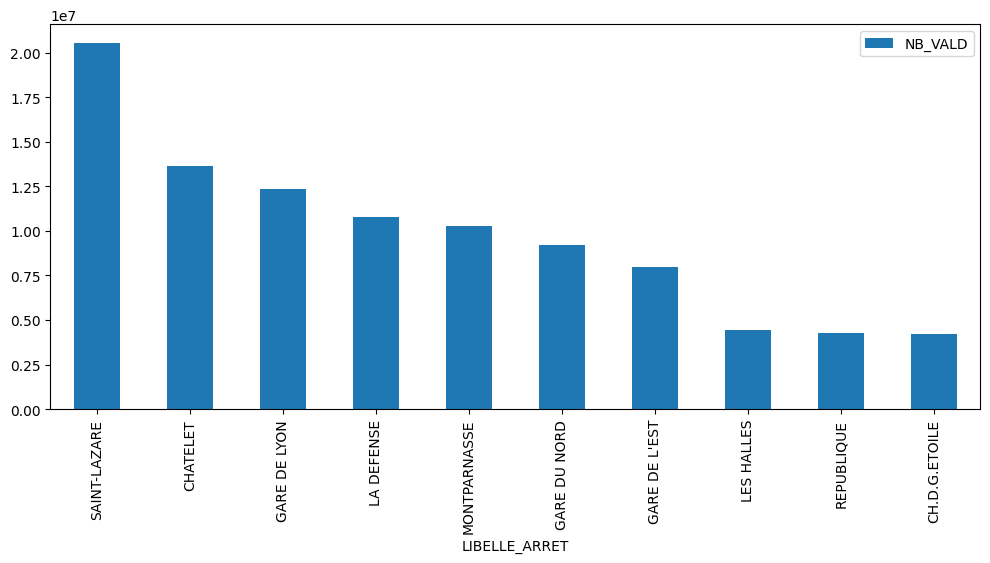

In [3]:
traffic_rf.head(10).plot(
    kind="bar",
    x="LIBELLE_ARRET",
    y="NB_VALD",
    figsize=(12,5)
)

On trouve que les stations les plus fréquentées sont les grandes gares parisiennes, et d'autres stations qui sont des noeuds comme Châtelet ou La Défense

Visualisons sur une carte

In [4]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]2m2/3 [folium]


Construction de la liste des stations avec coordonnées GPS

In [5]:
# 0. Lecture GTFS
stops = pd.read_csv("data/gtfs/stops.txt")
routes = pd.read_csv("data/gtfs/routes.txt")
trips = pd.read_csv("data/gtfs/trips.txt")
stop_times = pd.read_parquet("data/gtfs/stop_times.parquet")

# 1. Associer stop_id et route_type
routes_small = routes[["route_id", "route_type"]]
trips_small = trips[["trip_id", "route_id"]]
stop_times_small = stop_times[["trip_id", "stop_id"]]

stop_trip = stop_times_small.merge(trips_small, on="trip_id", how="left")
stop_route = stop_trip.merge(routes_small, on="route_id", how="left")

stop_route = stop_route[["stop_id", "route_type"]].drop_duplicates()

# 2. Sélectionner les stations
rail_like_types = [1, 2] #métro, train
stop_rail = stop_route[stop_route["route_type"].isin(rail_like_types)]

stops_rail = stops.merge(
    stop_rail[["stop_id"]].drop_duplicates(),
    on="stop_id",
    how="inner"
)

# 3. Regrouper les quais : utiliser parent_station
stops_rail["station_id"] = stops_rail["parent_station"].fillna(stops_rail["stop_id"])

stations = (
    stops_rail
    .groupby("station_id", as_index=False)
    .agg({
        "stop_name": "first",
        "stop_lon": "mean",
        "stop_lat": "mean"
    })
)

# 4. Passage en GeoDataFrame pour l'analyse
CRS_WGS84 = "EPSG:4326"
CRS_LAMBERT93 = "EPSG:2154"

stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations["stop_lon"], stations["stop_lat"]),
    crs=CRS_WGS84
)

stations_proj_rf = stations_gdf.to_crs(CRS_LAMBERT93)
stations_proj_rf = stations_proj_rf.rename(columns={"stop_name": "station_name"})

/tmp/ipykernel_9138/2283762908.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv("data/gtfs/trips.txt")


Merge des coordonnées GPS sur les validations

In [6]:
#Les clés uniques des stations ne sont pas exactement les mêmes dans les données de validations et les données GTFS
traffic_rf["ID_ZDC"] = traffic_rf["ID_ZDC"].astype(int)
traffic_rf["stop_id"] = "IDFM:" + traffic_rf["ID_ZDC"].astype(str)

stations_vald_rf = stations_proj_rf.merge(traffic_rf,left_on = "station_id",right_on="stop_id",how="inner")
#le inner permet d'exclure les gares non-présentes dans les validations
stations_vald_rf = stations_vald_rf[["station_id","station_name","stop_lon","stop_lat","geometry","NB_VALD"]]

Construction de la carte avec des cercles proportionnels au nombre de validations dans la station

In [ ]:
df = stations_vald_rf.copy()

# Vérifier que les colonnes lat/lon sont bien float
df['stop_lat'] = df['stop_lat'].astype(float)
df['stop_lon'] = df['stop_lon'].astype(float)
df['NB_VALD'] = df['NB_VALD'].astype(float)

# Normaliser rayon pour la visualisation
max_radius = 30
df['radius'] = df['NB_VALD'] / df['NB_VALD'].max() * max_radius
df['radius'] = df['radius'].clip(lower=2)  # pour que même les petites valeurs soient visibles

# Création de la carte
m = folium.Map(location=[48.85, 2.35], zoom_start=12)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=row['radius'],
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['station_name']}: {int(row['NB_VALD']):,} validations"
    ).add_to(m)

# Ajuster la vue pour inclure tous les points
m.fit_bounds(df[['stop_lat','stop_lon']].values.tolist())

m  # affichage de la carte


On retrouve bien les stations les plus fréquentées : Saint-Lazare, Châtelet, La Défense, Montparnasse, Gare de Lyon, Gare du Nord... Globalement toutes les stations les plus fréquentées sont situées dans Paris, sauf La Défense.

Notre première théorie pour justifier la fréquentation d'une station est de savoir s'il s'agit d'un noeud (plusieurs lignes passent par cette station). Elle semble être vérifiée au vu de cette première carte. Regardons si nous pouvons confirmer cela.

In [8]:
# Filtrer réseau ferré
rail_routes = routes[routes["route_type"].isin([1, 2])]  # 1=Métro, 2=Train/RER
print(f" Nombre de lignes ferrées détectées : {rail_routes.shape[0]}")

# stop_id -> trip -> route
stop_trip = stop_times.merge(trips[["trip_id", "route_id"]], on="trip_id", how="left")
stop_trip_route = stop_trip.merge(rail_routes[["route_id", "route_short_name"]], on="route_id", how="inner")

# Regroupement station physique via parent_station 
stops["station_id"] = stops["parent_station"].fillna(stops["stop_id"])
stop_trip_route = stop_trip_route.merge(stops[["stop_id", "station_id"]], on="stop_id", how="left")

# Nombre de lignes uniques par station ferrée
station_lignes = (
    stop_trip_route.groupby("station_id")["route_short_name"]
    .nunique()
    .reset_index()
    .rename(columns={"route_short_name": "nb_lignes_fer"})
)
# Fusion avec validations 
df_nb_lignes = stations_vald_rf.merge(station_lignes, on="station_id", how="left")
df_nb_lignes = df_nb_lignes.drop_duplicates(subset=["station_id"], keep="first")

df_nb_lignes.sort_values(by="nb_lignes_fer",ascending=False).head(10)

 Nombre de lignes ferrées détectées : 41


,station_id,station_name,stop_lon,stop_lat,geometry,NB_VALD,nb_lignes_fer
507,IDFM:71410,Gare du Nord,2.356961,48.880938,POINT (652840.406 6864738.559),9182447.0,7
498,IDFM:71370,Gare Saint-Lazare,2.325168,48.876032,POINT (650504.147 6864212.594),20559184.0,7
691,IDFM:73626,Gare de Lyon,2.373654,48.844754,POINT (654032.649 6860705.399),12328284.0,6
417,IDFM:71139,Gare Montparnasse,2.321927,48.842503,POINT (650234.412 6860486.497),10255590.0,6
528,IDFM:71517,La Défense,2.238255,48.892014,POINT (644146.767 6866047.667),10767994.0,5
147,IDFM:63880,Versailles Chantiers,2.134787,48.795112,POINT (636442.417 6855351.489),1611110.0,5
456,IDFM:71264,Châtelet,2.346952,48.858625,POINT (652085.82 6862263.6),13665229.0,5
494,IDFM:71359,Gare de l'Est,2.358318,48.876573,POINT (652935.935 6864252.428),7987855.0,5
561,IDFM:71673,Nation,2.395872,48.848338,POINT (655666.304 6861091.222),3466761.0,5
474,IDFM:71311,République,2.363942,48.867539,POINT (653340.359 6863244.55),4296079.0,5


In [9]:
#Test de corrélation 
df_nb_lignes["NB_VALD"].corr(df_nb_lignes["nb_lignes_fer"])

np.float64(0.7069744132165796)

On obtient une corrélation forte (>0.7) mais pas au point que ce soit une preuve que les stations multi-lignes soient des hubs majeurs. 

Visualisons plus précisément le lien entre nombre de lignes et validations :

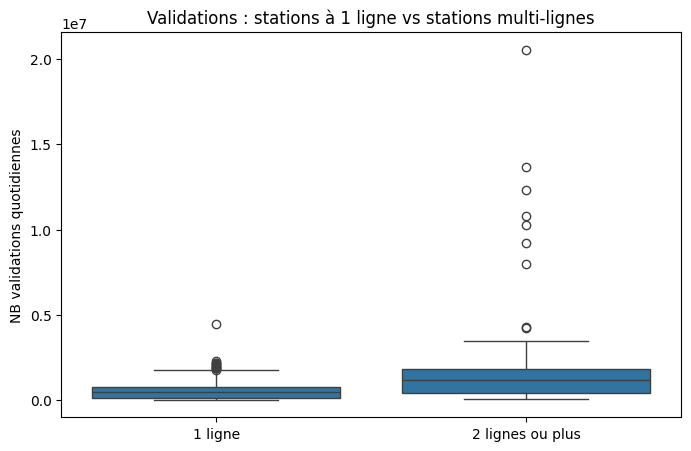

Médiane 1 seule ligne : 444798.5
Médiane multilignes : 1168455.0


In [ ]:
df_nb_lignes["multi"] = df_nb_lignes["nb_lignes_fer"].apply(lambda x: "1 ligne" if x==1 else "2 lignes ou plus")

#1 ligne VS Multilignes
plt.figure(figsize=(8,5))
sns.boxplot(data=df_nb_lignes, x="multi", y="NB_VALD")
plt.title("Validations : stations à 1 ligne vs stations multi-lignes")
plt.ylabel("NB validations quotidiennes")
plt.xlabel("")
plt.show()

print("Médiane 1 seule ligne :",df_nb_lignes[df_nb_lignes["multi"] == "1 ligne"]["NB_VALD"].median())
print("Médiane multilignes :",df_nb_lignes[df_nb_lignes["multi"] == "2 lignes ou plus"]["NB_VALD"].median())

On constate que la médiane des stations à plusieurs lignes est quasiment 3 fois plus grande que celle des stations à une seule ligne. L'hypothèse est vraisemblable.

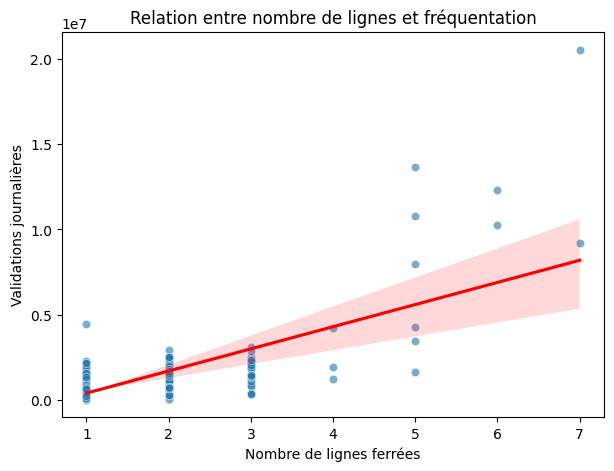

In [11]:
#Nuage de points
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_nb_lignes, x="nb_lignes_fer", y="NB_VALD", alpha=0.6)
sns.regplot(data=df_nb_lignes, x="nb_lignes_fer", y="NB_VALD", scatter=False, color="red")
plt.title("Relation entre nombre de lignes et fréquentation")
plt.xlabel("Nombre de lignes ferrées")
plt.ylabel("Validations journalières")
plt.show()

On observe bien qu'en moyenne : plus il y a de lignes qui passent dans une station, plus elle est fréquentée. Mais il ne semble pas y avoir de relation linéaire, certains points sont très éloignés de la droite rouge.

Fréquentation moyenne par nombre de lignes :

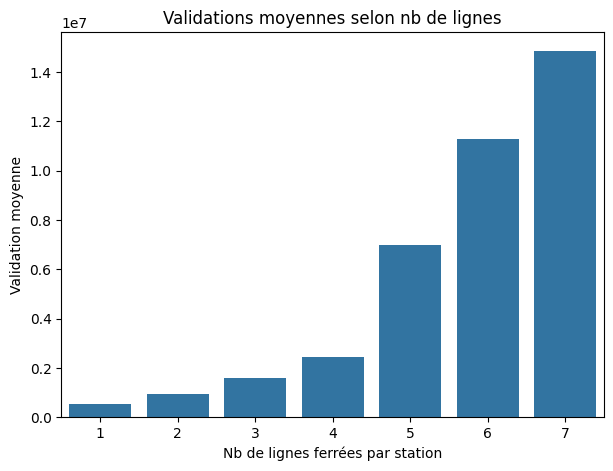

In [12]:
df_group = df_nb_lignes.groupby("nb_lignes_fer")["NB_VALD"].mean().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=df_group, x="nb_lignes_fer", y="NB_VALD")
plt.title("Validations moyennes selon nb de lignes")
plt.xlabel("Nb de lignes ferrées par station")
plt.ylabel("Validation moyenne")
plt.show()

Sur ce diagramme en bâton, on constate clairement que le nombre de validations augmente avec le nombre de lignes

**Conclusion de l'hypothèse 1 : les résultats confirment que les noeuds du réseau sont très fréquentés.**

### II. 2. Visualisation des POI récupérés

**H2 : Un environnement urbain dense fait augmenter la fréquentation d'une station**

Carte des poi

Superposer stations et poi pour voir les endroits qui invalident l'hypothèse

In [ ]:
stations_gdf = stations_gdf.rename(columns={"stop_name":"station_name"}) #on reprend le GeoDataFrame
stations_proj_rf = stations_gdf.to_crs(CRS_LAMBERT93)

def poi_autour(path, rayon=500):
    """
    Compte le nombre de POI autour de chaque station dans un rayon donné (en mètres).
    """
    gdf = gpd.read_parquet(path)
    
    # Assurer que le CRS est correct
    if gdf.crs is None or gdf.crs.to_string() != "EPSG:2154":
        gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:2154")
    
    # Créer buffer autour des stations
    buffers = stations_proj_rf[["station_id", "geometry"]].copy()
    buffers["geometry"] = buffers.geometry.buffer(rayon)
    
    # Jointure spatiale : POI à l'intérieur du buffer
    hits = gpd.sjoin(gdf[["geometry"]], buffers, how="inner", predicate="within")
    
    # Comptage par station
    poi_par_station = (
        hits.groupby("station_id")
        .size()
        .reset_index()
        .rename(columns={0: "nb_poi"})
    )
    return poi_par_station

poi_categories = [
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"
]

def tableau_poi_global(stations_gdf, rayon=500):
    """
    Agrège tous les POI autour des stations pour toutes les catégories.
    Retourne un DataFrame pandas avec station_id et nb_poi par catégorie.
    """
    resultat = None

    for cat in poi_categories:
        print(f"Traitement de la catégorie : {cat}")
        
        gdf_cat = poi_autour("data/poi/" + cat + ".parquet", rayon)
        gdf_cat = gdf_cat.rename(columns={"nb_poi": f"{cat}"})
        
        if resultat is None:
            resultat = gdf_cat
        else:
            # Merge uniquement sur station_id pour éviter conflit avec station_name
            resultat = resultat.merge(gdf_cat, on="station_id", how="outer")
    
    # Remplacer les NaN par 0
    resultat = resultat.fillna(0)
    
    return resultat

In [14]:
# stations_gdf doit être en Lambert 93 (EPSG:2154)
df_poi = tableau_poi_global(stations_proj_rf, rayon=500)

# Fusion avec les validations
df_final = stations_vald_rf.merge(df_poi, on="station_id", how="left")
df_final.fillna(0, inplace=True)
df_final.head(3)

Traitement de la catégorie : poi_commerce_proximite
Traitement de la catégorie : poi_commerce_majeur
Traitement de la catégorie : poi_education2
Traitement de la catégorie : poi_sante2
Traitement de la catégorie : poi_culture
Traitement de la catégorie : poi_logement
Traitement de la catégorie : poi_bureaux2
Traitement de la catégorie : poi_restaurants
Traitement de la catégorie : poi_administration2
Traitement de la catégorie : poi_sports_loisirs


,station_id,station_name,stop_lon,stop_lat,geometry,NB_VALD,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs
0,IDFM:412687,Pernety,2.318359,48.834121,POINT (649964.47 6859556.75),708730.0,105.0,0.0,29.0,6.0,1.0,979.0,20.0,102.0,3.0,18.0
1,IDFM:412697,Noisy-le-Grand - Mont d'Est,2.550027,48.840885,POINT (666974 6860187),2109880.0,24.0,1.0,13.0,1.0,1.0,15.0,5.0,13.0,1.0,4.0
2,IDFM:412992,Boucicaut,2.287856,48.841073,POINT (647732.5 6860349.5),789365.0,68.0,0.0,26.0,4.0,2.0,370.0,9.0,66.0,3.0,10.0


In [15]:
df_numerique = df_final[["NB_VALD",
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"]]
df_numerique.corr()

,NB_VALD,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs
NB_VALD,1.000000,0.343320,0.331881,0.208643,0.213151,0.274893,0.221037,0.342369,0.315364,0.285363,0.003103
poi_commerce_proximite,0.343320,1.000000,0.464892,0.707326,0.601235,0.849755,0.795369,0.776996,0.953495,0.625374,0.071429
poi_commerce_majeur,0.331881,0.464892,1.000000,0.204096,0.169286,0.412548,0.205864,0.490581,0.534329,0.366485,-0.092434
poi_education2,0.208643,0.707326,0.204096,1.000000,0.626099,0.583489,0.729281,0.574673,0.633817,0.504770,0.281573
poi_sante2,0.213151,0.601235,0.169286,0.626099,1.000000,0.445035,0.638725,0.618953,0.529005,0.352780,0.202081
poi_culture,0.274893,0.849755,0.412548,0.583489,0.445035,1.000000,0.638470,0.588268,0.848525,0.561415,0.004140
poi_logement,0.221037,0.795369,0.205864,0.729281,0.638725,0.638470,1.000000,0.619961,0.750176,0.528951,0.169572
poi_bureaux2,0.342369,0.776996,0.490581,0.574673,0.618953,0.588268,0.619961,1.000000,0.785783,0.514498,0.063896
poi_restaurants,0.315364,0.953495,0.534329,0.633817,0.529005,0.848525,0.750176,0.785783,1.000000,0.633100,0.004436
poi_administration2,0.285363,0.625374,0.366485,0.504770,0.352780,0.561415,0.528951,0.514498,0.633100,1.000000,0.010251


Visualisation de la matrice de corréation

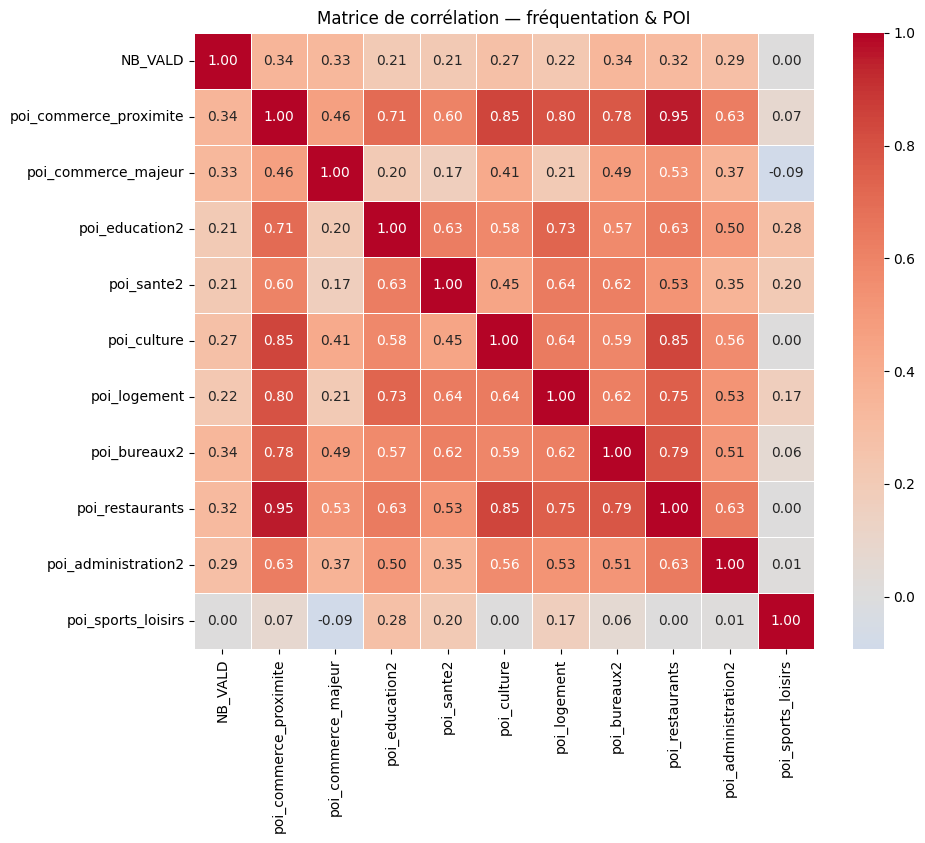

In [16]:
# Heatmap
corr = df_numerique.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,          # valeurs écrites
    cmap="coolwarm",     # palette lisible
    center=0,            # neutre = pas de lien
    linewidths=.7,       # séparation visuelle
    fmt=".2f"            # arrondi lisible
)
plt.title("Matrice de corrélation — fréquentation & POI")
plt.show()


On observe une corrélation de 0.75 entre logements et restaurants. Pour la suite, on ne gardera que logement car restaurants n'apporte pas beaucoup pour l'explication.

On enlève aussi sports_loisirs qui ne semble pas avoir de lien avec validations. Peut-être car les installations sportives n'ont pas du tout les mêmes attractivités (Stade de France VS Golf de Saint-Fargeau)

In [17]:
df_final["poi_attractivite"] = (df_final["poi_commerce_proximite"] 
+ df_final["poi_commerce_majeur"]
+ df_final["poi_education2"]
+ df_final["poi_sante2"]
+ df_final["poi_culture"]
+ df_final["poi_bureaux2"]
+ df_final["poi_administration2"] 
)
#+ df_final["poi_logement"]

df_final["NB_VALD"].corr(df_final["poi_attractivite"])

np.float64(0.3476727285139017)

Quand on ajoute logement on passe à 0.26 de corrélation, car logement a des chiffres beaucoup plus grands que les autres colonnes. Donc on décide de normaliser pour inclure toutes les variables de poi

In [18]:
df_final["poi_attractivite_norm"] = (df_final["poi_commerce_proximite"]/471 
+ df_final["poi_commerce_majeur"]/13
+ df_final["poi_education2"]/51
+ df_final["poi_sante2"]/37
+ df_final["poi_culture"]/29
+ df_final["poi_bureaux2"]/61
+ df_final["poi_administration2"]/11 
+ df_final["poi_logement"]/1311
)

df_final["NB_VALD"].corr(df_final["poi_attractivite_norm"])

np.float64(0.3463529516879067)

In [ ]:
#carte des poi, à superposer avec la carte des stations
#cercles bleus, leur taille dépend du nombre de poi total. Superposer avec cercles rouges

# Fusionner si ce n'est pas déjà fait :
df = df_final.copy()

# Normalisation rayon validations
df["radius_vald"] = (df["NB_VALD"] / df["NB_VALD"].max() * 30).clip(lower=2)

# Normalisation rayon POI attractivité
df["radius_poi"] = (df["poi_attractivite_norm"] / df["poi_attractivite_norm"].max() * 30).clip(lower=2)

# Carte
m = folium.Map(location=[48.85, 2.35], zoom_start=12)

# CERCLES VALIDATIONS (ROUGE)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["stop_lat"], row["stop_lon"]],
        radius=row["radius_vald"],
        color="red",
        fill=True,
        fill_opacity=0.4,
        popup=f"{row['station_name']}<br>Validations : {int(row['NB_VALD']):,}"
    ).add_to(m)

# CERCLES ATTRACTIVITÉ POI (BLEU)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["stop_lat"], row["stop_lon"]],
        radius=row["radius_poi"],
        color="blue",
        fill=True,
        fill_opacity=0.35,
        popup=f"{row['station_name']}<br>Attractivité POI : {row['poi_attractivite_norm']:.2f}"
    ).add_to(m)

# Ajuste la vue
m.fit_bounds(df[['stop_lat','stop_lon']].values.tolist())

m


Remarques : (à réécrire)
- Certaines stations extrêmement fréquentées (Gare du Nord, Châtelet, Saint-Lazare…) peuvent avoir beaucoup de validations mais pas proportionnellement plus de POI à proximité immédiate. Notamment pour les grandes gares (Gare de Lyon, Gare du Nord, Gare Saint-Lazare...), on ne prend pas en compte le fait qu'une gare est un point d'intérêt majeur.
- Effet des outliers : les stations “hub” peuvent écraser la corrélation si elles sont très au-dessus de la moyenne.

Solution ? On peut essayer une régression linéaire (ou log-log) (cf partie modélisation) on verra ou mettre cette partie 

### II. 3. Offre de transport

**H3 : qualité service**

On calcule le nombre de trains qui passent en heure de pointe du matin sur un jour de semaine jugé représentatif

In [ ]:
gtfs_dir = "data/gtfs"
gtfs_dir = Path(gtfs_dir)

calendar = pd.read_csv(gtfs_dir / "calendar.txt")
trips = pd.read_csv(gtfs_dir / "trips.txt")
stop_times = pd.read_parquet(gtfs_dir / "stop_times.parquet")
stops = pd.read_csv(gtfs_dir / "stops.txt")
calendar_dates = pd.read_csv(gtfs_dir / "calendar_dates.txt")
routes = pd.read_csv(gtfs_dir / "routes.txt")

# Choisir un jour réel et déterminer les service_id actifs
date = pd.Timestamp("2025-12-08") #on prend lundi 8 décembre
dint = int(date.strftime("%Y%m%d"))

active = calendar[
    (calendar["start_date"] <= dint) &
    (calendar["end_date"]   >= dint) &
    (calendar["monday"] == 1)
]["service_id"]

# Exceptions (ajouts/suppressions) ce jour-là
exc = calendar_dates[calendar_dates["date"] == dint]
to_remove = set(exc.loc[exc["exception_type"] == 2, "service_id"])
to_add    = set(exc.loc[exc["exception_type"] == 1, "service_id"])

active = set(active) - to_remove
active |= to_add

# Harmoniser types
trips["service_id"] = trips["service_id"].astype(str)
active_ids = pd.Index(sorted(map(str, active)))

# 2) Filtrer l’offre ferroviaire (route_type) et les trips actifs
# Ferroviaire classique : route_type == 2, Métro : route_type == 1
rail_routes = routes[routes["route_type"].isin([2,1])] 
trips_day = trips[trips["service_id"].isin(active_ids) &
                  trips["route_id"].isin(rail_routes["route_id"])]

# 3) Lier aux stop_times et calculer l’heure de passage
# On compte un passage par (trip_id, stop_id) : distinct trip_id à un stop
# Utilise arrival_time OU departure_time (une seule, pour ne pas double-compter).

st = stop_times[stop_times["trip_id"].isin(trips_day["trip_id"])].copy()

# Conversion robuste HH:MM:SS -> minutes, en gérant >24:00:00
def to_min(t):
    if not isinstance(t, str) or t.count(":") != 2:
        return None
    h, m, s = map(int, t.split(":"))
    return h*60 + m + s/60

# Choix de la colonne temps (arrival_time conseillé pour "passage")
st["t_min"] = st["arrival_time"].map(to_min)

# 4) Filtrer la fenêtre 07:00–10:00 (bornes inclusives/exclusives au choix)
mask_window = (st["t_min"] >= 7*60) & (st["t_min"] < 10*60)
st_peak = st.loc[mask_window, ["trip_id","stop_id"]].dropna()

# 5) Compter les trains par station
# N.B. on compte des trips DISTINCTS par stop_id pour éviter les doublons.
trains_par_station = (st_peak.drop_duplicates(["trip_id","stop_id"])
                            .groupby("stop_id", as_index=False)
                            .size()
                            .rename(columns={"size":"trains_7_10"}))

# 6) Joindre les libellés (stop_name) et parent_station 
stops_small = stops[["stop_id","stop_name","parent_station"]].copy()
res = trains_par_station.merge(stops_small, on="stop_id", how="left")

# Agréger au niveau "station" (parent_station) si les quais sont séparés pour avoir une ligne par vraie station
if "parent_station" in stops.columns and stops["parent_station"].notna().any():
    res_station = (res.assign(parent_station=res["parent_station"].fillna(res["stop_id"]))
                     .groupby("parent_station", as_index=False)["trains_7_10"].sum()
                     .merge(stops[["stop_id","stop_name"]], left_on="parent_station", right_on="stop_id", how="left")
                     .rename(columns={"stop_name":"station_name"})
                     .drop(columns=["stop_id"]))
    # res_station : trains par "station" (groupé)

res_station = res_station.sort_values(by="trains_7_10",ascending=False)
res_station.head(10)

/tmp/ipykernel_9138/3422434776.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(gtfs_dir / "trips.txt")


,parent_station,trains_7_10,station_name
538,IDFM:71370,979,Gare Saint-Lazare
496,IDFM:71264,920,Châtelet
514,IDFM:71311,866,République
595,IDFM:71673,838,Nation
457,IDFM:71139,761,Gare Montparnasse
546,IDFM:71410,687,Gare du Nord
529,IDFM:71347,664,Charles de Gaulle - Etoile
722,IDFM:73626,620,Gare de Lyon
534,IDFM:71359,597,Gare de l'Est
59,IDFM:463564,535,Bastille


Visualisation

On retrouve les noeuds (logique : plus il y a de demande, plus il faut de trains). Métros plus fréquents que RER (grae du nord n'est pas là alors que c'est un noueud / République est bien plus haut dans le classement ici que pour la fréquentation car 5 lignes de métro)

In [21]:
df_offre_vald = df_final.merge(res_station,left_on = "station_id", right_on = "parent_station", how="left")
df_offre_vald["NB_VALD"].corr(df_offre_vald["trains_7_10"])

np.float64(0.7100618772694068)

On obtient une corrélation à 0.7 ce qui est plutot attendu. 

Conclusion H3

## III. Modélisation

### Régression de nb_vald sur les poi

In [ ]:
X = df_final[["poi_attractivite"]]
X = sm.add_constant(X)
y = df_final["NB_VALD"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                NB_VALD   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     100.8
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.62e-22
Time:                        19:01:04   Log-Likelihood:                -11363.
No. Observations:                 735   AIC:                         2.273e+04
Df Residuals:                     733   BIC:                         2.274e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.732e+05   5.92e+04  

Interprétation : 
- Coeff de poi_attractivité = 4797: cela signifie qu’en moyenne, chaque POI d’attractivité supplémentaire dans le rayon autour de la station est associé à ~4797 validations en plus par ytimèstre (en supposant que tout le reste reste constant).
- p-value à 0.00 : Statistiquement parlant, ce coefficient est hautement significatif.

Limites : 
- Le modèle est linéaire et univarié, donc il ne contrôle pas les autres facteurs comme la densité résidentielle ou la présence d’autres lignes.
- Les stations hubs très fréquentées peuvent influencer le coefficient (effet d’outlier).
- La causalité n’est pas établie : ce sont des associations, pas des relations de cause à effet.

### Régression de NB_VALD sur nombre de lignes et nombre de trains

In [ ]:
df = df_nb_lignes.merge(df_offre_vald,on="station_id",how="inner")

y = df["NB_VALD_x"]
X = df[["trains_7_10"]]

print("Corrélation nb_lignes / offre :",df["nb_lignes_fer"].corr(df["trains_7_10"]))

model = sm.OLS(y, X).fit()
print(model.summary())

Corrélation nb_lignes / offre : 0.6832053931091471
                                 OLS Regression Results                                
Dep. Variable:              NB_VALD_x   R-squared (uncentered):                   0.628
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              1240.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):                   7.22e-160
Time:                        19:01:04   Log-Likelihood:                         -11196.
No. Observations:                 735   AIC:                                  2.239e+04
Df Residuals:                     734   BIC:                                  2.240e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025  

Développer un peu la partie modélisation

Mettre nombre de poi et offre/nb de trains dans une même régression ?

## IV. Limites du projet (et pistes possibles)

### IV. 1. Limites des données de validations

Les données de validations, comme leur nom l'indique, mesurent le nombre de personnes qui ont validé un titre de transport dans une station. Ainsi, cela prend en compte uniquement les entrées et pas les sorties. Dans la plupart des cas cela n'a pas grande importance car on peut supposer qu'il y a à peu près autant d'entrées que de sorties dans une station (car les voyageurs font des allers-retours), mais illustrons tout de même cette limite avec un exemple :


In [ ]:
df_metro = df_rf[df_rf["CODE_STIF_RES"] == "110"] #on sélectionne les stations de métro
traffic_metro = df_metro.groupby(["ID_ZDC", "LIBELLE_ARRET"])["NB_VALD"].sum().reset_index().sort_values("NB_VALD", ascending=True)
traffic_metro.head(10)

,ID_ZDC,LIBELLE_ARRET,NB_VALD
74,71166.0,EGLI.D'AUTEUIL,42277.0
210,71828.0,PELLEPORT,73113.0
225,71911.0,PRE-ST-GERVAIS,94174.0
222,71900.0,BUTTES-CHAUM.,109472.0
226,71920.0,BOLIVAR,129784.0
227,71930.0,DANUBE,133791.0
214,71860.0,SAINT-FARGEAU,156165.0
63,71141.0,CHARDON-LAGACH,173759.0
76,71169.0,PTE D'AUTEUIL,175211.0
272,73641.0,FALGUIERE,210605.0


On observe que la station de métro la moins fréquentée d'Ile de France (d'assez loin en plus) est Eglise d'Auteuil, située dans le 16e arrondissement sur la ligne 10. Alors même que selon des chiffres d'IDFM, la ligne 10 transporte près de 11 fois plus de voyageurs par an que les lignes 3 bis et 7 bis, dont les stations apparaissent juste après dans le classement (Pelleport, Pré Saint-Gervais...). Cela s'explique par le fait qu'Eglise d'Auteuil est une station où les voyageurs descendent beaucoup plus qu'ils ne montent, car la ligne 10 ne s'y arrête que dans un seul sens. On peut donc supposer que la fréquentation de la station Eglise d'Auteuil est bien supérieure à ce qu'on obtient dans nos données.

De la même façon, les données de validation ne donnent pas d'information sur les correspondances. Par exemple, à Châtelet - Les Halles, lorsqu'une personne fait une correspondance entre une ligne de RER et une ligne de métro (par exemple du RER B à la ligne 1), elle est amenée à passer par un portique, ce qui compte comme une validation. Par contre, en cas de correspondances entre 2 lignes de RER (par exemple du RER B au RER A), la personne change simplement de quai sans passer par un portique, et donc ce n'est pas compté dans les données de validation.

De plus, les validations ne prennent bien sûr pas en compte la fraude, qui peut sensiblement varier selon la zone géographique.

### IV. ?. Limites des POI

In [26]:
df_final.sort_values(by="poi_sports_loisirs",ascending=False).head(5)

,station_id,station_name,stop_lon,stop_lat,geometry,NB_VALD,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs,poi_attractivite,poi_attractivite_norm
111,IDFM:62172,Saint-Fargeau,2.542610,48.565026,POINT (666252 6829520.577),5921.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,1.0,0.0,46.0,0.0,0.023646
399,IDFM:71084,Porte de Saint-Cloud,2.256918,48.837978,POINT (645458.6 6860026.25),1215585.0,47.0,0.0,10.0,5.0,0.0,233.0,11.0,46.0,1.0,42.0,74.0,0.879965
355,IDFM:70543,Gentilly,2.340927,48.815228,POINT (651603.5 6857442),500667.0,25.0,0.0,11.0,1.0,2.0,559.0,1.0,18.0,0.0,37.0,40.0,0.807543
179,IDFM:64949,Villennes-sur-Seine,1.999557,48.939831,POINT (626713 6871559.828),57320.0,4.0,0.0,3.0,0.0,0.0,7.0,0.0,4.0,1.0,33.0,8.0,0.163565
327,IDFM:69950,Créteil Pompadour,2.435316,48.771254,POINT (658499.5 6852499),858869.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,0.002123


On observe que la station ayant le plus de poi dans la catégorie sports et loisirs autour d'elles est Saint-Fargeau, une gare du RER D située en Seine-et-Marne. Il y a bien des infrastructures sportives près de cette gare, mais ces infrastructures ne génèrent pas tant de déplacement. Par exemple face au Parc des Princes (situé à côté de la station Porte de Saint-Cloud, deuxième de ce classement) où sont organisés régulièrement de grands évènements, comme des matchs de football ou des concerts.

## Conclusion